### Weighted cross entropy loss (to enable smaller differences between predicted & true classes)
### More data
### EarlyStop tolerance: 20 epochs

In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import keras
import functools
import itertools
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 200
BASE_DIR = '../project/all_females_combined'
RATING_PATH = 'ratings_stefan_combined.txt'
VERSION = 'v5.1-more-data-tol20'

In [3]:
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in itertools.product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

In [4]:
def prepareData(percentage,rating_path):
    # Read in ratings
    ratings = np.genfromtxt(rating_path)
    
    # Round (obviously imbalanced sets)
    ratings = np.round(ratings, 0).astype(np.int8)
    print(np.unique(ratings, return_counts=True))
    
    ### Distribute images across folders
    for r in np.unique(ratings).astype(np.int8):
        if not os.path.isdir('./data/train/{}-stars'.format(r)):
            os.makedirs('./data/train/{}-stars'.format(r))
        if not os.path.isdir('./data/test/{}-stars'.format(r)):
            os.makedirs('./data/test/{}-stars'.format(r))
                
    ### Move all images according to ratings
    images = sorted(os.listdir(BASE_DIR))

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]

    for i in test_ind:
        src = os.path.join(BASE_DIR, images[i])
        dest = os.path.join('./data/test/{}-stars'.format(ratings[i]), images[i])
        shutil.copy(src, dest)
        
    for i in train_ind:
        src = os.path.join(BASE_DIR, images[i])
        dest = os.path.join('./data/train/{}-stars'.format(ratings[i]), images[i])
        shutil.copy(src, dest)
        
    return ratings[train_ind], train_ind, ratings[test_ind], test_ind, ratings, images

In [5]:
def getGenerator():
    datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                preprocessing_function=utils.preprocess_input)

    train_generator = datagen.flow_from_directory(
                                './data/train/',
                                target_size=(IMG_SIZE, IMG_SIZE),
                                batch_size=64,
                                class_mode='categorical'#, save_to_dir='aug_data/train', save_prefix='aug_train', save_format='png'
                                )

    test_generator = datagen.flow_from_directory(
                            './data/test/',
                            target_size=(IMG_SIZE, IMG_SIZE),
                            batch_size=64,
                            class_mode='categorical'#, save_to_dir='aug_data/test', save_prefix='aug_test', save_format='png'
                            )

    return train_generator, test_generator

In [6]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def visualize_acc(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training acc")
    plt.plot(epochs, val_loss, 'r', label="Validation acc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [8]:
def recommend(images, test_ind, pred_classes):
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(BASE_DIR, images[test_ind[i]]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

In [9]:
y_train, train_ind, y_test, test_ind, ratings, images = prepareData(5,RATING_PATH)
train_generator, test_generator = getGenerator()

(array([0, 1, 2, 3, 4, 5], dtype=int8), array([122, 190, 150, 113, 119,  24]))
Found 683 images belonging to 6 classes.
Found 35 images belonging to 6 classes.


In [10]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation='relu', name='fc6')(last_layer)
X = Dropout(0.2)(X)
X = Dense(128, activation='relu', name='fc7')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation='relu', name='fc8')(X)
X = Dropout(0.2)(X)
output = Dense(len(np.unique(ratings)), activation='softmax')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False
    
# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

#prepare weights for crossentropy
#we want to punish large differences in stars
w_array = np.ones((6,6))
for i in range(6):
        for j in range(6):
            w_array[i, j] = np.abs(i - j)
            
ncce = functools.partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ = 'w_categorical_crossentropy'
ncce.__doc__ = 'weighted categorical_crossentropy'

model.compile(optimizer=Adam(lr= 0.0005,clipnorm=1.0),
              loss=ncce, 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./weights-'+ VERSION +'.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=540//64,
    epochs=500,
    class_weight=class_weight,
    validation_data=test_generator,
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
8/8 [==============================] - 15s 2s/step - loss: 19.8936 - acc: 0.2569 - val_loss: 23.2082 - val_acc: 0.2286

Epoch 00001: val_loss improved from inf to 23.20824, saving model to ./weights-v5.1-more-data-tol20.hdf5
Epoch 2/500
8/8 [==============================] - 6s 712ms/step - loss: 21.4578 - acc: 0.2012 - val_loss: 15.5963 - val_acc: 0.2286

Epoch 00002: val_loss improved from 23.20824 to 15.59634, saving model to ./weights-v5.1-more-data-tol20.hdf5
Epoch 3/500
8/8 [==============================] - 5s 680ms/step - loss: 17.8890 - acc: 0.2889 - val_loss: 14.4780 - val_acc: 0.3143

Epoch 00003: val_loss improved from 15.59634 to 14.47802, saving model to ./weights-v5.1-more-data-tol20.hdf5
Epoch 4/500
8/8 [==============================] - 6s 733ms/step - loss: 22.8117 - acc: 0.1895 - val_loss: 24.1941 - val_acc: 0.2571

Epoch 00004: val_loss did not improve
Epoch 5/500
8/8 [==============================] - 6s 691ms/step - loss: 21.8866 - acc: 0.2296 - val_lo

8/8 [==============================] - 6s 696ms/step - loss: 12.2546 - acc: 0.3839 - val_loss: 8.2962 - val_acc: 0.5429

Epoch 00044: val_loss improved from 8.30726 to 8.29618, saving model to ./weights-v5.1-more-data-tol20.hdf5
Epoch 45/500
8/8 [==============================] - 6s 693ms/step - loss: 11.7367 - acc: 0.4027 - val_loss: 8.5658 - val_acc: 0.4571

Epoch 00045: val_loss did not improve
Epoch 46/500
8/8 [==============================] - 6s 727ms/step - loss: 10.9533 - acc: 0.4219 - val_loss: 10.3570 - val_acc: 0.4857

Epoch 00046: val_loss did not improve
Epoch 47/500
8/8 [==============================] - 5s 677ms/step - loss: 10.3056 - acc: 0.4557 - val_loss: 12.6810 - val_acc: 0.3714

Epoch 00047: val_loss did not improve
Epoch 48/500
8/8 [==============================] - 6s 728ms/step - loss: 11.8899 - acc: 0.3906 - val_loss: 9.9352 - val_acc: 0.4857

Epoch 00048: val_loss did not improve
Epoch 49/500
8/8 [==============================] - 6s 691ms/step - loss: 14.3417

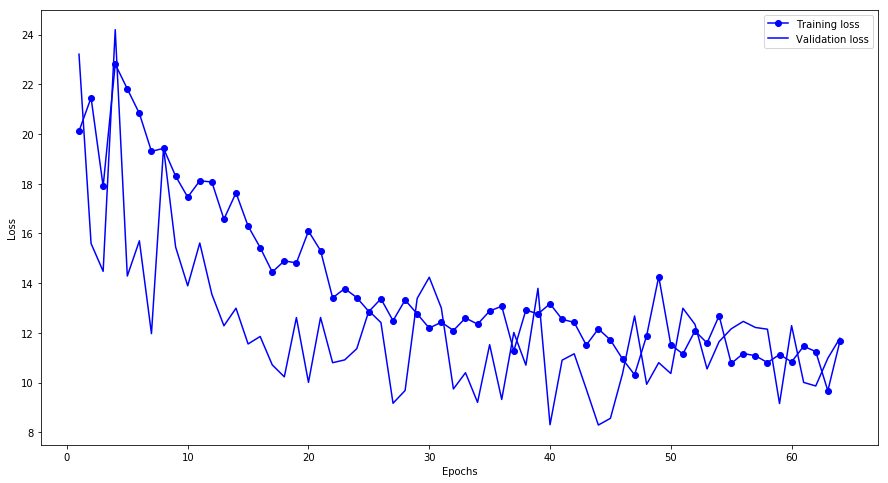

In [12]:
visualize_loss(history)

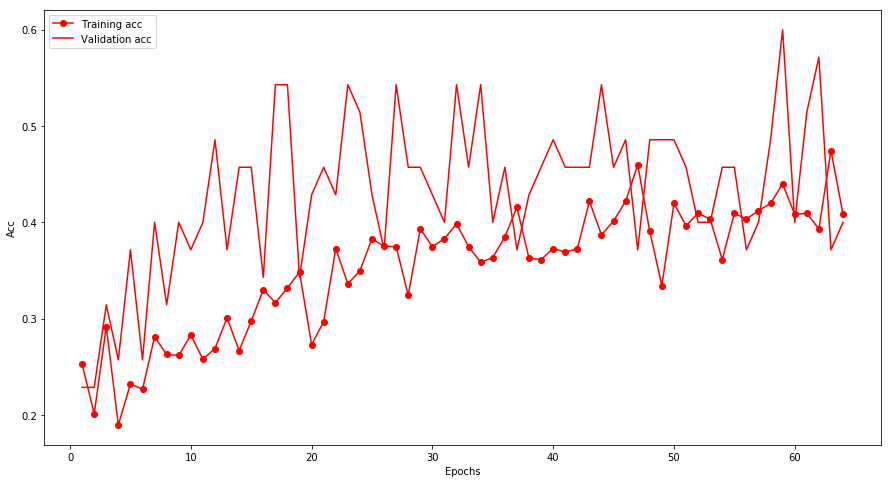

In [13]:
visualize_acc(history)

In [14]:
model.save('./models/love_classifier'+ VERSION +'.h5')

In [15]:
#get test data (unmodified)
data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
last_set = 0

for idx, _im in enumerate(images): #iterate over images
    if idx in test_ind:
        _img = image.load_img(os.path.join(BASE_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data_test[last_set, :, :, :] = utils.preprocess_input(_x, version=1) / .255
        last_set += 1
    
predictions = model.predict(data_test)
pred_classes = predictions.argmax(axis=-1)

y_true = np.array(y_test)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

[2 0 4 4 1 0 2 3 0 4 2 1 3 1 1 5 1 2 0 3 5 2 4 0 0 0 0 0 4 0 2 4 0 2 1]
[0 0 1 1 0 4 0 1 0 0 1 0 1 2 0 0 4 2 1 2 4 0 0 0 1 1 1 0 2 2 4 2 4 4 4]


array([[4, 4, 1, 0, 2, 0],
       [3, 0, 1, 0, 2, 0],
       [3, 1, 1, 0, 2, 0],
       [0, 2, 1, 0, 0, 0],
       [2, 2, 2, 0, 0, 0],
       [1, 0, 0, 0, 1, 0]])

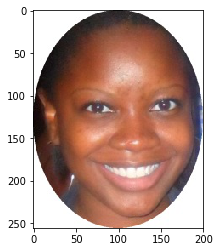

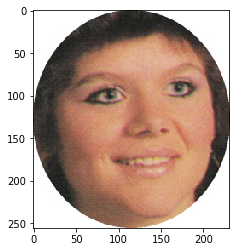

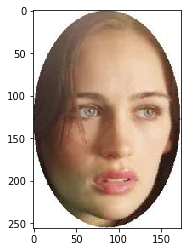

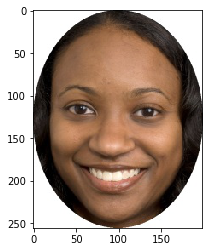

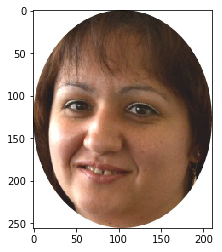

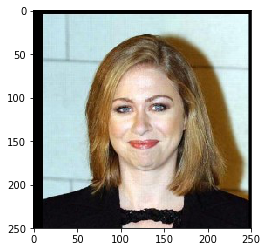

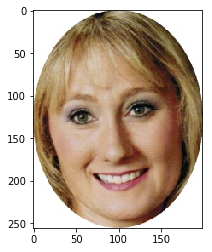

In [16]:
recommend(images,test_ind,pred_classes)